In [1]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings(action='ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
print(keras.__version__)

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

2.5.0
2.5.0


In [2]:
#GPU 사용 설정, -1이면 CPU 사용
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], 
#                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
# #     tf.config.experimental.set_virtual_device_configuration(gpus[1], 
# #                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

# 필요한 데이터 로드, split

In [4]:
import random    
seed_num = 42
random.seed(seed_num)
path = '/project/LSH/'
X = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[idx[:i],:,:], y[idx[:i]]
X_test, y_test = X[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4068), (6182,), (1545, 10, 4068), (1545,))

In [5]:
fi = pd.read_csv('./data/df_all_best_type.csv')

In [6]:
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

# Model

In [7]:
model = tf.keras.models.load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# Base predict

In [8]:
base_pred = model.predict(X_test)
base_pred

array([[0.85767746],
       [0.88165766],
       [0.8160955 ],
       ...,
       [0.84174216],
       [0.9241806 ],
       [0.8296366 ]], dtype=float32)

In [39]:
df = pd.DataFrame(base_pred, columns=['base_pred'])

In [40]:
df

,base_pred
0,0.857677
1,0.881658
2,0.816095
3,0.948484
4,0.950073
...,...
1540,0.702797
1541,0.113465
1542,0.841742
1543,0.924181


<AxesSubplot:ylabel='base_pred'>

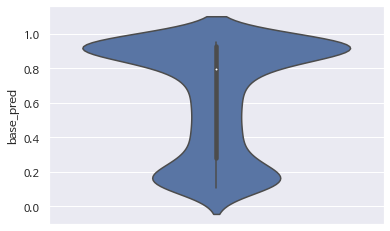

In [42]:
sns.violinplot(data=df, y='base_pred')

In [49]:
result = []
for i in tqdm(range(5)):
    save_cols = X_test[:,:,i].copy()
    #Change all values to 1
    X_test[:,:,i] = 1
    #Predict
    pred = model.predict(X_test)
    #Result
    result.append({'feature' : str(COLS[i]), 'value' : pred.flatten()})
    #값 복원
    X_test[:,:,i] = save_cols

  0%|          | 0/5 [00:00<?, ?it/s]

In [51]:
temp = pd.DataFrame(result)
temp

,feature,value
0,0,"[0.84638953, 0.88165766, 0.80914575, 0.9484841..."
1,50803,"[0.8111261, 0.8608668, 0.78237534, 0.94776237,..."
2,50804,"[0.8787147, 0.9001107, 0.8507263, 0.94903886, ..."
3,50805,"[0.7988835, 0.85508037, 0.7661241, 0.9473384, ..."
4,50806,"[0.8883041, 0.9068321, 0.8587693, 0.94994557, ..."


<AxesSubplot:>

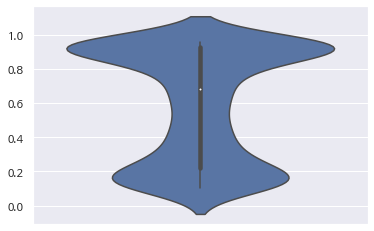

In [58]:
sns.violinplot(data=temp.iloc[1], y='value')